In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

# From a Spreadsheet

In [3]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

# Reading from Disk with tf.data

Let's say you have a bunch of images at E:\WallabiesAndRoosFullSize\train\kangaroos

In [4]:
import os

In [5]:
root_path = 'E:/WallabiesAndRoosFullSize/train/kangaroos'

In [6]:
path_list = os.listdir(root_path)

In [7]:
paths = [os.path.join(root_path, path) for path in path_list]

In [8]:
paths[:5]

['E:/WallabiesAndRoosFullSize/train/kangaroos\\kangaroo-10.jpg',
 'E:/WallabiesAndRoosFullSize/train/kangaroos\\kangaroo-100.jpg',
 'E:/WallabiesAndRoosFullSize/train/kangaroos\\kangaroo-101.jpg',
 'E:/WallabiesAndRoosFullSize/train/kangaroos\\kangaroo-102.jpg',
 'E:/WallabiesAndRoosFullSize/train/kangaroos\\kangaroo-103.jpg']

In [9]:
dataset_images = tf.data.Dataset.from_tensor_slices(paths)

Our labels are all the same for these, so we can just call them `1`. We'll make a vector of these values.

In [10]:
#labels = [1] * len(paths)

In [11]:
#dataset_labels = tf.data.Dataset.from_tensor_slices(labels)

Then we need a parse function

In [12]:
batch_size = 4

In [13]:
def parse_image(filename):
    img = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(img, channels=3)
    image = tf.image.convert_image_dtype(image_decoded, tf.float32)
    image = tf.image.resize(image, (256, 256))
    
    # then do the label
    parts = tf.strings.split(filename, os.sep)
    label = parts[1]
    return image, label

In [15]:
#dataset = tf.data.Dataset.zip((dataset_images, dataset_labels))
dataset = dataset_images
dataset = dataset.map(parse_image)
dataset = dataset.batch(batch_size)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


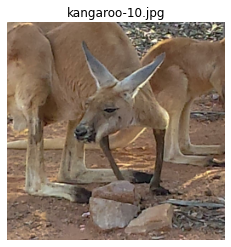

In [16]:
file_path = next(iter(dataset_images))
image, label = parse_image(file_path)

def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label.numpy().decode('utf-8'))
    plt.axis('off')

show(image, label)

## Using TF Datasets

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from functools import partial
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# load in the tf_flowers dataset
data, info= tfds.load(name="tf_flowers", split="train", as_supervised=True, with_info=True)
data

In [ ]:
info

In [ ]:
def process_image(image, label, img_size):
    # cast and normalize image
    image = tf.image.convert_image_dtype(image, tf.float32)
    # apply simple augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image,[img_size, img_size])
    return image, label

ds_tf = data.map(partial(process_image, img_size=120), num_parallel_calls=AUTOTUNE).batch(30).prefetch(AUTOTUNE)
ds_tf

In [ ]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()

    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

In [ ]:
view_image(ds_tf)

In [17]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

Small datasets you can keep in memory - just load it in as a numpy array. You could also do a pandas dataframe

In [18]:
abalone_train = pd.read_csv(
    "https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv",
    names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
           "Viscera weight", "Shell weight", "Age"])

abalone_train.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,0.435,0.335,0.110,0.334,0.1355,0.0775,0.0965,7
1,0.585,0.450,0.125,0.874,0.3545,0.2075,0.2250,6
2,0.655,0.510,0.160,1.092,0.3960,0.2825,0.3700,14
3,0.545,0.425,0.125,0.768,0.2940,0.1495,0.2600,16
4,0.545,0.420,0.130,0.879,0.3740,0.1695,0.2300,13


In [19]:
abalone_features = abalone_train.copy()
abalone_labels = abalone_features.pop('Age')

In [20]:
abalone_features = np.array(abalone_features)
abalone_features

array([[0.435, 0.335, 0.11 , ..., 0.136, 0.077, 0.097],
       [0.585, 0.45 , 0.125, ..., 0.354, 0.207, 0.225],
       [0.655, 0.51 , 0.16 , ..., 0.396, 0.282, 0.37 ],
       ...,
       [0.53 , 0.42 , 0.13 , ..., 0.374, 0.167, 0.249],
       [0.395, 0.315, 0.105, ..., 0.118, 0.091, 0.119],
       [0.45 , 0.355, 0.12 , ..., 0.115, 0.067, 0.16 ]])

In [21]:
abalone_model = tf.keras.Sequential([
  layers.Dense(64),
  layers.Dense(1)
])

abalone_model.compile(loss = tf.losses.MeanSquaredError(),
                      optimizer = tf.optimizers.Adam())

In [22]:
abalone_model.fit(abalone_features, abalone_labels, epochs=10)


Epoch 1/10
104/104 [==============================] - 0s 885us/step - loss: 65.0552
Epoch 2/10
104/104 [==============================] - 0s 865us/step - loss: 12.6076
Epoch 3/10
104/104 [==============================] - 0s 846us/step - loss: 8.6339
Epoch 4/10
104/104 [==============================] - 0s 821us/step - loss: 8.1037
Epoch 5/10
104/104 [==============================] - 0s 817us/step - loss: 7.6461
Epoch 6/10
104/104 [==============================] - 0s 802us/step - loss: 7.2623
Epoch 7/10
104/104 [==============================] - 0s 805us/step - loss: 6.9621
Epoch 8/10
104/104 [==============================] - 0s 808us/step - loss: 6.7439
Epoch 9/10
104/104 [==============================] - 0s 808us/step - loss: 6.6003
Epoch 10/10
104/104 [==============================] - 0s 798us/step - loss: 6.4800


# Normalizing models

In [23]:
normalize = preprocessing.Normalization()

"Then you use the Normalization.adapt() method to adapt the normalization layer to your data."

In [24]:
normalize.adapt(abalone_features)


In [25]:
norm_abalone_model = tf.keras.Sequential([
  normalize,
  layers.Dense(64),
  layers.Dense(1)
])

norm_abalone_model.compile(loss = tf.losses.MeanSquaredError(),
                           optimizer = tf.optimizers.Adam())

norm_abalone_model.fit(abalone_features, abalone_labels, epochs=10)

Epoch 1/10
104/104 [==============================] - 0s 1ms/step - loss: 91.0378
Epoch 2/10
104/104 [==============================] - 0s 779us/step - loss: 50.6088
Epoch 3/10
104/104 [==============================] - 0s 817us/step - loss: 14.9321
Epoch 4/10
104/104 [==============================] - 0s 817us/step - loss: 5.6431
Epoch 5/10
104/104 [==============================] - 0s 824us/step - loss: 5.0315
Epoch 6/10
104/104 [==============================] - 0s 793us/step - loss: 4.9793
Epoch 7/10
104/104 [==============================] - 0s 861us/step - loss: 4.9545
Epoch 8/10
104/104 [==============================] - 0s 808us/step - loss: 4.9391
Epoch 9/10
104/104 [==============================] - 0s 767us/step - loss: 4.9351
Epoch 10/10
104/104 [==============================] - 0s 799us/step - loss: 4.9568


## Titanic example

In [27]:
titanic = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [28]:
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')

In [29]:
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')

In [30]:
inputs = {}

for name, column in titanic_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'sex': <tf.Tensor 'sex:0' shape=(None, 1) dtype=string>,
 'age': <tf.Tensor 'age:0' shape=(None, 1) dtype=float32>,
 'n_siblings_spouses': <tf.Tensor 'n_siblings_spouses:0' shape=(None, 1) dtype=float32>,
 'parch': <tf.Tensor 'parch:0' shape=(None, 1) dtype=float32>,
 'fare': <tf.Tensor 'fare:0' shape=(None, 1) dtype=float32>,
 'class': <tf.Tensor 'class:0' shape=(None, 1) dtype=string>,
 'deck': <tf.Tensor 'deck:0' shape=(None, 1) dtype=string>,
 'embark_town': <tf.Tensor 'embark_town:0' shape=(None, 1) dtype=string>,
 'alone': <tf.Tensor 'alone:0' shape=(None, 1) dtype=string>}

In [31]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<tf.Tensor 'normalization_1/truediv:0' shape=(None, 4) dtype=float32>

In [32]:
preprocessed_inputs = [all_numeric_inputs]

In [33]:
preprocessed_inputs

[<tf.Tensor 'normalization_1/truediv:0' shape=(None, 4) dtype=float32>]

"For the string inputs use the preprocessing.StringLookup function to map from strings to integer indices in a vocabulary. Next, use preprocessing.CategoryEncoding to convert the indexes into float32 data appropriate for the model."

In [34]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue

  lookup = preprocessing.StringLookup(vocabulary=np.unique(titanic_features[name]))
  one_hot = preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

In [35]:
lookup

In [36]:
np.unique(titanic_features[name])

array(['n', 'y'], dtype=object)

## Normalizing

In [1]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

NameError: name 'tf' is not defined

In [2]:
Note: If you would like to scale pixel values to [-1,1] you can instead write Rescaling(1./127.5, offset=-1)

SyntaxError: invalid character in identifier (<ipython-input-2-b4b70bab1201>, line 1)

## Reading in an image

You'll read it in as a uint8, but at some point you'll want to convert it to a float (usually tf.float32 is good)

## More parsers

In [3]:
def parse(filename, label):
    img = tf.io.read_file(filename)
    image_decoded = tf.image.decode_png(img, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return image, label


dataset = tf.data.Dataset.zip((dataset_images, dataset_labels))
dataset = dataset.map(parse)
dataset = dataset.batch(batch_size)




# create dataset
ds_alb = dataset.map(partial(process_data, img_size=512)).prefetch(AUTOTUNE)
ds_alb


def set_shapes(img, label, img_shape=(512,512,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
ds_alb

SyntaxError: invalid character in identifier (<ipython-input-3-913a0f8c9941>, line 2)